In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


区间 201-300 回答数: 300，总 token 概率数: 78142
区间 301-400 回答数: 300，总 token 概率数: 75527
区间 401-600 回答数: 600，总 token 概率数: 138240


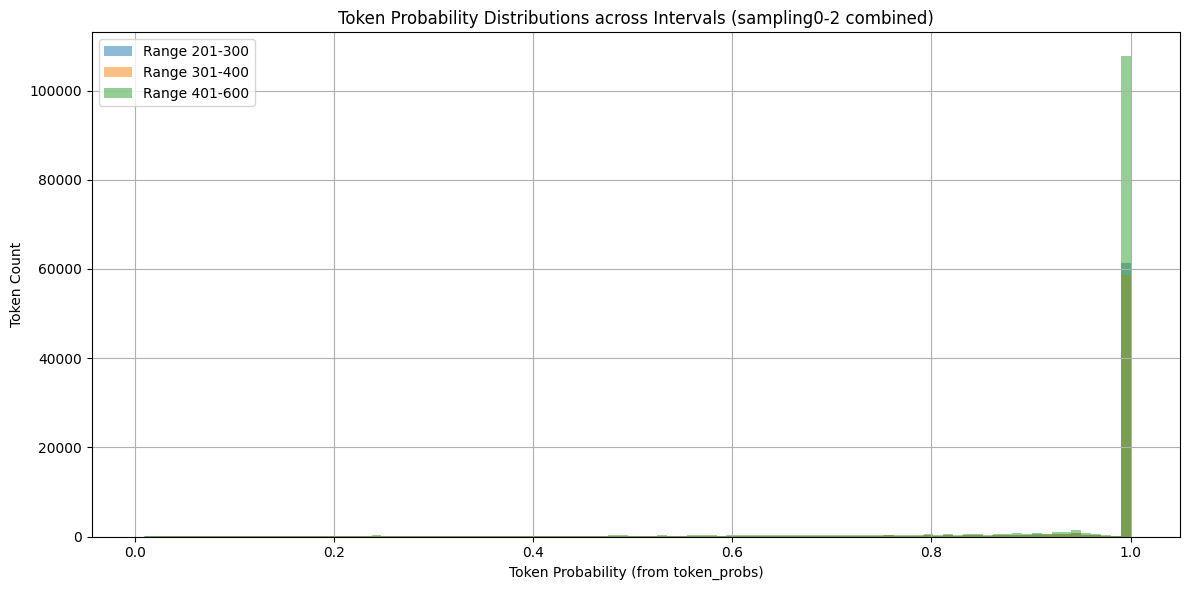

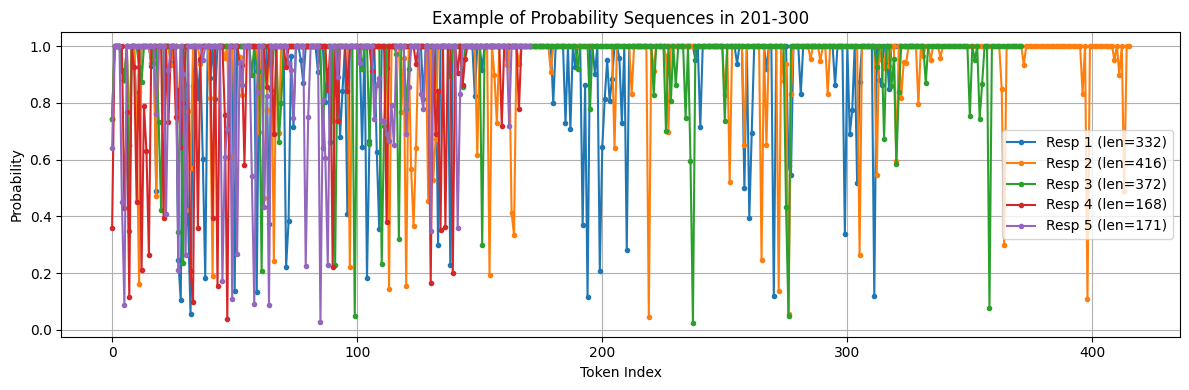

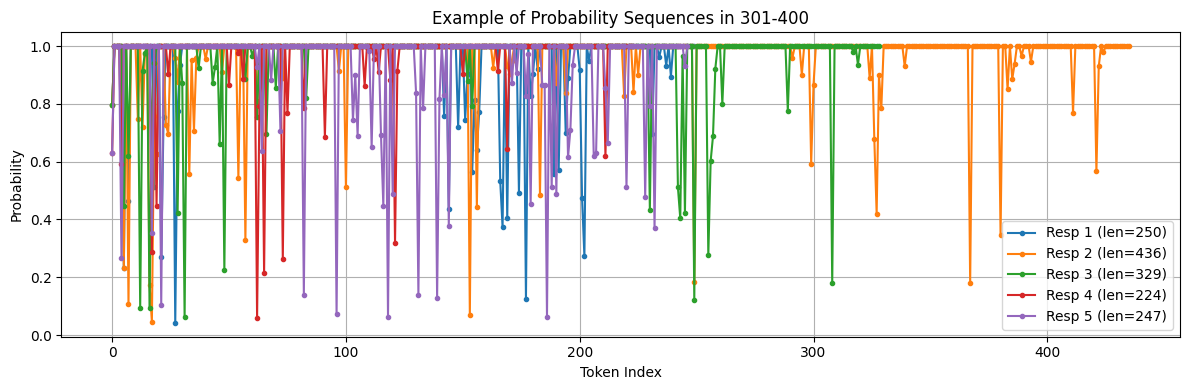

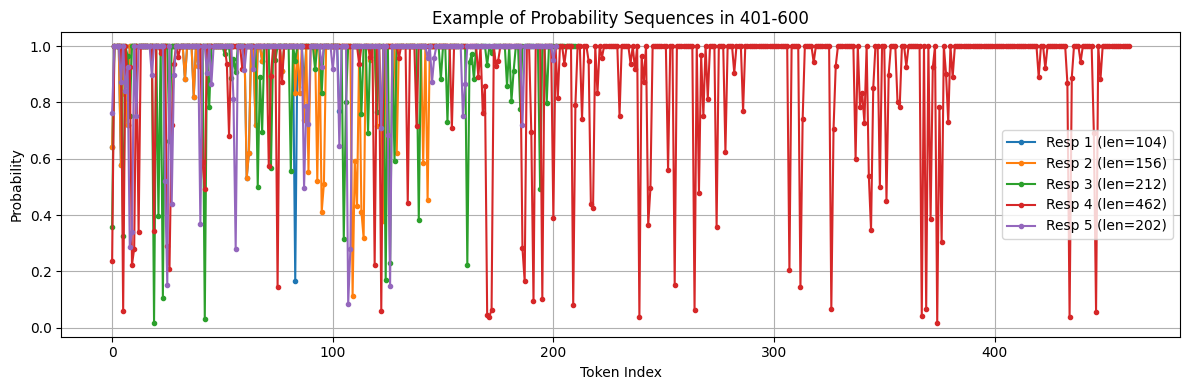

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ 参数设置
BASE_PATH = "/content/drive/MyDrive/Cluster-proj/output"
intervals = [(201, 300), (301, 400), (401, 600)]
samplings = ['sampling0', 'sampling1', 'sampling2']

# ✅ 存储所有区间的所有回答拼接后的概率
all_probs_by_interval = {f"{start}-{end}": [] for (start, end) in intervals}

# ✅ 同时保存每个回答的概率序列（用于可视化“W 型”回答分段情况）
all_responses_by_interval = {f"{start}-{end}": [] for (start, end) in intervals}

for start, end in intervals:
    range_tag = f"{start}-{end}"
    logits_file = f"{BASE_PATH}/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json"

    if not os.path.exists(logits_file):
        print(f"⚠️ 文件不存在: {logits_file}")
        continue

    with open(logits_file, 'r') as f:
        data = json.load(f)

    interval_probs = []
    responses_probs = []

    # 提取 sampling0-2 中的 token_probs
    for qid, qdata in data.items():
        for s in samplings:
            if s in qdata and 'token_probs' in qdata[s]:
                token_probs = qdata[s]['token_probs']

                # 只取第二个元素（概率值）
                probs = [p[1] for p in token_probs if isinstance(p, list) and len(p) == 2]

                if len(probs) > 0:
                    interval_probs.extend(probs)         # 拼接到全区间
                    responses_probs.append(probs)       # 每个回答单独保存

    all_probs_by_interval[range_tag] = np.array(interval_probs)
    all_responses_by_interval[range_tag] = responses_probs
    print(f"区间 {range_tag} 回答数: {len(responses_probs)}，总 token 概率数: {len(interval_probs)}")

# ✅ 绘制拼接后的直方图
plt.figure(figsize=(12, 6))
for tag, probs in all_probs_by_interval.items():
    if len(probs) > 0:
        plt.hist(probs, bins=100, alpha=0.5, label=f"Range {tag}")

plt.xlabel('Token Probability (from token_probs)')
plt.ylabel('Token Count')
plt.title('Token Probability Distributions across Intervals (sampling0-2 combined)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ 可视化：每个回答内的概率序列（检查是否分段）取 5 个样例
for tag, responses in all_responses_by_interval.items():
    plt.figure(figsize=(12, 4))
    for i, probs in enumerate(responses[:5]):   # 取前 5 个回答看看形状
        plt.plot(range(len(probs)), probs, marker='.', label=f"Resp {i+1} (len={len(probs)})")
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.title(f'Example of Probability Sequences in {tag}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


区间 201-300 回答数: 300，总 token 概率数 (sigmoid 后): 78142
区间 301-400 回答数: 300，总 token 概率数 (sigmoid 后): 75527
区间 401-600 回答数: 600，总 token 概率数 (sigmoid 后): 138240


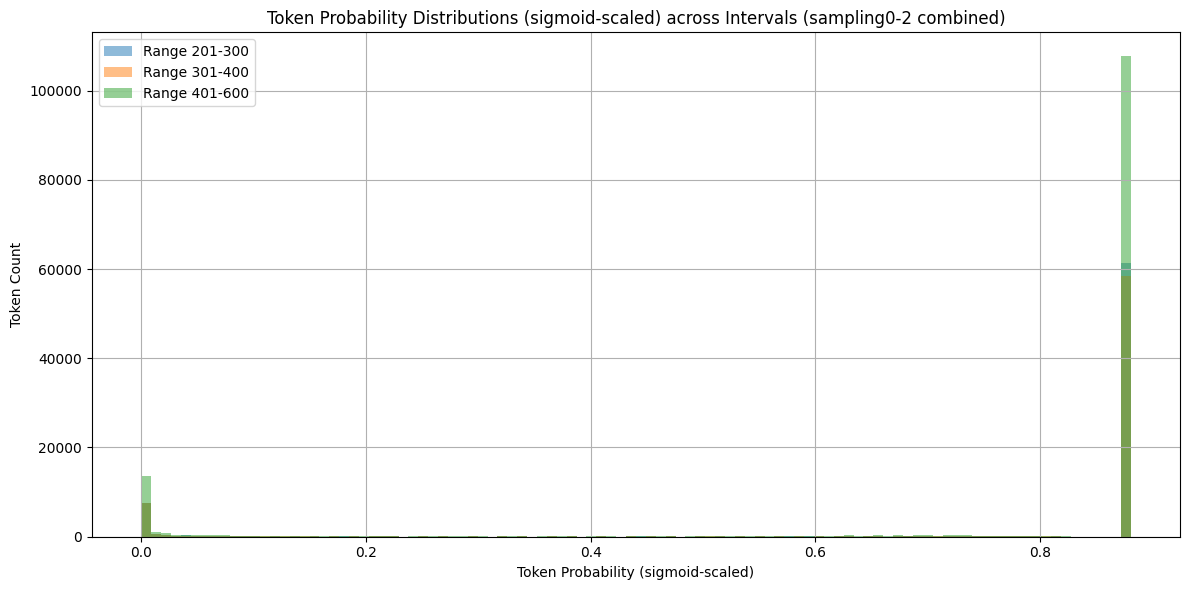

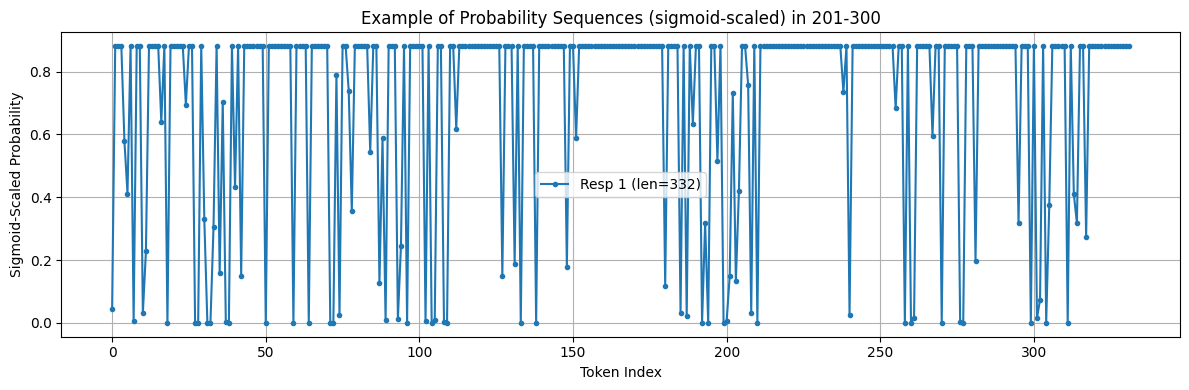

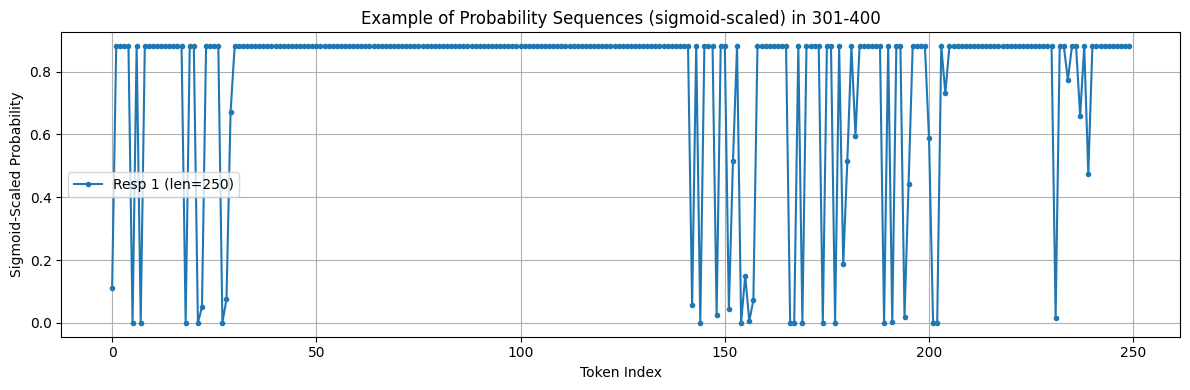

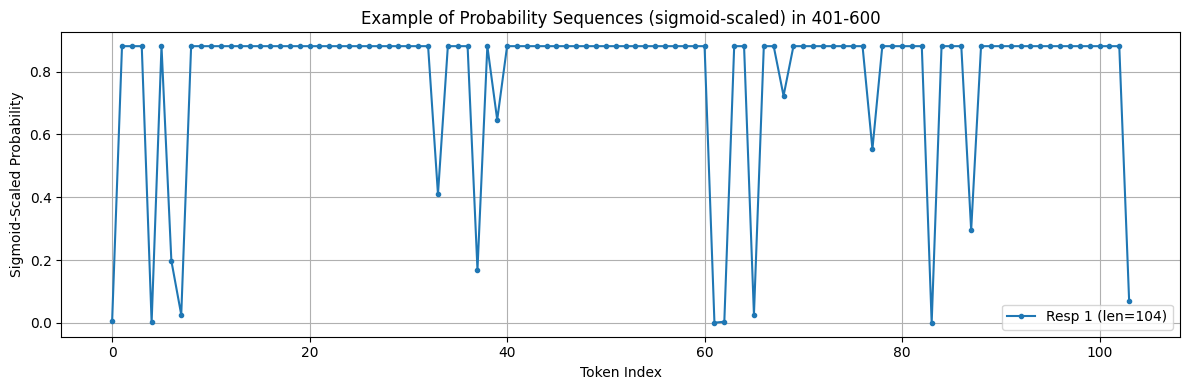

区间 201-300 平均 sigmoid 分数: 平均=0.3189, 方差=0.0007, 样本数=300
区间 301-400 平均 sigmoid 分数: 平均=0.3158, 方差=0.0008, 样本数=300
区间 401-600 平均 sigmoid 分数: 平均=0.3180, 方差=0.0007, 样本数=600


In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ sigmoid_scaled 函数
def sigmoid_scaled(x, center=0.9, scale=20):
    return 1 / (1 + np.exp(-scale * (x - center)))

def avg_sigmoid_score_scaled(probs, center=0.9, scale=20):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)
    return np.mean(sigmoid_scaled(probs, center=center, scale=scale))

# ✅ 参数设置
BASE_PATH = "/content/drive/MyDrive/Cluster-proj/output"
intervals = [(201, 300), (301, 400), (401, 600)]
samplings = ['sampling0', 'sampling1', 'sampling2']

# ✅ 存储所有区间的所有回答拼接后的概率（sigmoid 后）
all_probs_by_interval = {f"{start}-{end}": [] for (start, end) in intervals}

# ✅ 同时保存每个回答的概率序列（sigmoid 后）
all_responses_by_interval = {f"{start}-{end}": [] for (start, end) in intervals}

for start, end in intervals:
    range_tag = f"{start}-{end}"
    logits_file = f"{BASE_PATH}/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json"

    if not os.path.exists(logits_file):
        print(f"⚠️ 文件不存在: {logits_file}")
        continue

    with open(logits_file, 'r') as f:
        data = json.load(f)

    interval_probs = []
    responses_probs = []

    # 提取 sampling0-2 中的 token_probs
    for qid, qdata in data.items():
        for s in samplings:
            if s in qdata and 'token_probs' in qdata[s]:
                token_probs = qdata[s]['token_probs']

                # 只取第二个元素（概率值）
                probs = [p[1] for p in token_probs if isinstance(p, list) and len(p) == 2]

                if len(probs) > 0:
                    # 应用 sigmoid_scaled
                    sigmoid_probs = sigmoid_scaled(np.array(probs), center=0.9, scale=20)

                    interval_probs.extend(sigmoid_probs.tolist())    # 拼接到全区间
                    responses_probs.append(sigmoid_probs.tolist())   # 每个回答单独保存

    all_probs_by_interval[range_tag] = np.array(interval_probs)
    all_responses_by_interval[range_tag] = responses_probs
    print(f"区间 {range_tag} 回答数: {len(responses_probs)}，总 token 概率数 (sigmoid 后): {len(interval_probs)}")

# ✅ 绘制拼接后的直方图（sigmoid 后）
plt.figure(figsize=(12, 6))
for tag, probs in all_probs_by_interval.items():
    if len(probs) > 0:
        plt.hist(probs, bins=100, alpha=0.5, label=f"Range {tag}")

plt.xlabel('Token Probability (sigmoid-scaled)')
plt.ylabel('Token Count')
plt.title('Token Probability Distributions (sigmoid-scaled) across Intervals (sampling0-2 combined)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ 可视化：每个回答内的概率序列（sigmoid 后）取 5 个样例
for tag, responses in all_responses_by_interval.items():
    plt.figure(figsize=(12, 4))
    for i, probs in enumerate(responses[:1]):   # 取前 5 个回答看看形状
        plt.plot(range(len(probs)), probs, marker='.', label=f"Resp {i+1} (len={len(probs)})")
    plt.xlabel('Token Index')
    plt.ylabel('Sigmoid-Scaled Probability')
    plt.title(f'Example of Probability Sequences (sigmoid-scaled) in {tag}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ 计算每个回答的平均 sigmoid 分数
avg_sigmoid_scores_by_interval = {f"{start}-{end}": [] for (start, end) in intervals}

for tag, responses in all_responses_by_interval.items():
    for probs in responses:
        avg_score = avg_sigmoid_score_scaled(probs, center=0.9, scale=20)
        avg_sigmoid_scores_by_interval[tag].append(avg_score)

# ✅ 输出每个区间的平均 sigmoid 分数概览
for tag, avg_scores in avg_sigmoid_scores_by_interval.items():
    if len(avg_scores) > 0:
        print(f"区间 {tag} 平均 sigmoid 分数: 平均={np.mean(avg_scores):.4f}, 方差={np.var(avg_scores):.4f}, 样本数={len(avg_scores)}")


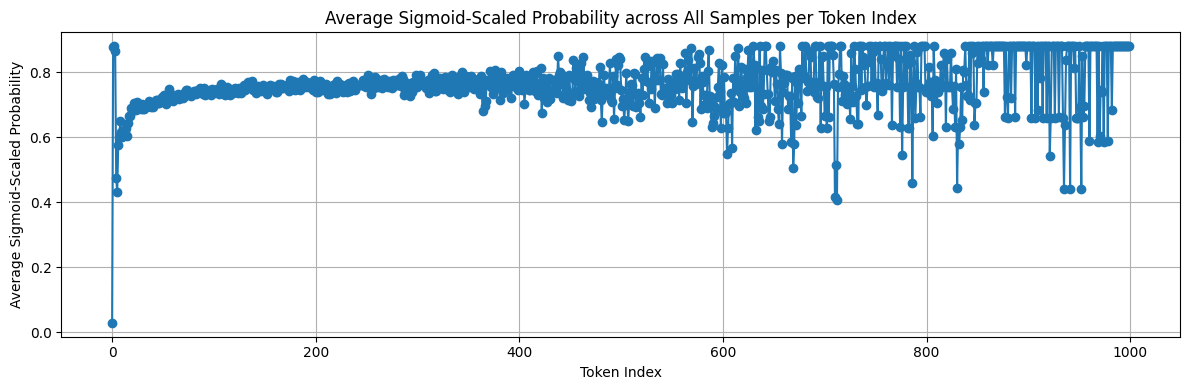

In [8]:
# ✅ 计算每个 index 上在所有样本的平均 sigmoid-scaled 概率
max_token_len = max(max(len(probs) for probs in responses) for responses in all_responses_by_interval.values())

# 初始化存储：每个 index 的所有样本值
token_probs_by_index = [[] for _ in range(max_token_len)]

# 填充每个 index 上的值
for responses in all_responses_by_interval.values():
    for probs in responses:
        for i, p in enumerate(probs):
            token_probs_by_index[i].append(p)

# 计算 index 平均值
avg_token_probs = [np.mean(token_vals) if len(token_vals) > 0 else 0.0 for token_vals in token_probs_by_index]

# ✅ 可视化平均值
plt.figure(figsize=(12, 4))
plt.plot(range(len(avg_token_probs)), avg_token_probs, marker='o')
plt.xlabel('Token Index')
plt.ylabel('Average Sigmoid-Scaled Probability')
plt.title('Average Sigmoid-Scaled Probability across All Samples per Token Index')
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ 参数设置
BASE_PATH = "/content/drive/MyDrive/Cluster-proj/output"
intervals = [(201, 300), (301, 400), (401, 600)]
samplings = ['sampling0', 'sampling1', 'sampling2']

# ✅ 存储所有区间的所有回答拼接后的概率
all_probs_by_interval = {f"{start}-{end}": [] for (start, end) in intervals}

# ✅ 同时保存每个回答的概率序列（用于可视化“W 型”回答分段情况）
all_responses_by_interval = {f"{start}-{end}": [] for (start, end) in intervals}

for start, end in intervals:
    range_tag = f"{start}-{end}"
    logits_file = f"{BASE_PATH}/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json"

    if not os.path.exists(logits_file):
        print(f"⚠️ 文件不存在: {logits_file}")
        continue

    with open(logits_file, 'r') as f:
        data = json.load(f)

    interval_probs = []
    responses_probs = []

    # 提取 sampling0-2 中的 token_probs
    for qid, qdata in data.items():
        for s in samplings:
            if s in qdata and 'token_probs' in qdata[s]:
                token_probs = qdata[s]['token_probs']

                # 只取第二个元素（概率值）
                probs = [p[1] for p in token_probs if isinstance(p, list) and len(p) == 2]

                if len(probs) > 0:
                    interval_probs.extend(probs)         # 拼接到全区间
                    responses_probs.append(probs)       # 每个回答单独保存

    all_probs_by_interval[range_tag] = np.array(interval_probs)
    all_responses_by_interval[range_tag] = responses_probs
    print(f"区间 {range_tag} 回答数: {len(responses_probs)}，总 token 概率数: {len(interval_probs)}")

# ✅ 绘制拼接后的直方图
plt.figure(figsize=(12, 6))
for tag, probs in all_probs_by_interval.items():
    if len(probs) > 0:
        plt.hist(probs, bins=100, alpha=0.5, label=f"Range {tag}")

plt.xlabel('Token Probability (from token_probs)')
plt.ylabel('Token Count')
plt.title('Token Probability Distributions across Intervals (sampling0-2 combined)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ 修改：每个回答单独画折线图（不再合并在一个图里）
for tag, responses in all_responses_by_interval.items():
    for i, probs in enumerate(responses):
        plt.figure(figsize=(10, 4))
        plt.plot(range(len(probs)), probs, marker='.', linestyle='-', color='blue')
        plt.xlabel('Token Index')
        plt.ylabel('Probability')
        plt.title(f'Probability Sequence in {tag} - Response {i+1} (len={len(probs)})')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Output hidden; open in https://colab.research.google.com to view.